# Usage instructions for the `icenumerics` simulation package

The `icenumerics` package is a collection of classes and routines intended to facilitate the simulations of colloidal ice. The actual simulation is done by [LAMMPS](http://lammps.sandia.gov), using a Brownian dynamics modification found in [Lammps_brownian](https://github.com/anyuzx/Lammps_brownian), as well as some custom modifications. For the complete lammps source, please clone the fork of lammps found [here](https://github.com/aortiza/lammps).

This package works by defining a colloidal ice system, creating LAMMPS input scripts, running them through a `os.system` command, and then reading the result from the `.lammpstrj` file. One advantage of this approach is that the output files can be read at a later time even after the workspace has been reset.

It goes without saying that this is a very early development program and should not be expected to do many more things than what are shown here. However, if you have a suggestion for further functionality, you can raise an [issue](https://github.com/aortiza/icenumerics/issues). And if you want to contribute, you can fork your copy of the package, and then do a pull request. 

## Importing the package

The package is easily imported by writing
    
    import icenumerics as ice

In [1]:
# This only adds the package to the path.
import os
import sys 
sys.path.insert(0, '../')

import icenumerics as ice

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

## About units.

The dimensions of the package are managed using the package `pint`. This pacakge defines a registry that contains many common units. These units can be assigned to a quantity by multiplication. For example, suppose we want to calculate the magnetic dipole moment of a particle. We have the expression:

$$ {\bf m} = \frac{V\chi{\bf B}}{\mu_0}$$

and the parameters are, 
* ${\bf B} = 30 \mathrm{mT}\ \hat{z}$
* $r = 5\mu{m}$
* $\chi = 0.5$

and $\mu_0 = 4\pi\times10^{-7} \mathrm{H}m^{-1}$

Then we can write:

In [2]:
import pint
import numpy as np

ureg = pint.UnitRegistry()

B = 30*ureg.mT
r = 5*ureg.um
chi = 0.5
mu0 = 4e-7*np.pi*ureg.H/ureg.m

V = 4/3*np.pi*r**3

m = V*B*chi/mu0
m.to_base_units()

<Quantity(6.2499999999999994e-12, 'ampere * meter ** 2')>

Which, as we can see, handles well the units for us. 

### Importing the unit registry
One caveat of using `pint` for unit management is that units from one unit registry can't operate with units from another unit registry. Therefore, for quantities defined in this script to be able to operate with quantities defined inside the `icenumerics` module, we need to use the unit registry of the module. This is easily done by writing:

In [3]:
ureg = ice.ureg

## The Spin Ice object

The first step towards a simulation is to construct a spin ice object. The spin ice will work as a template for the geometry of the colloidal ice later. 

To construct a spin ice object, we can write:

In [4]:
sp = ice.spins()
sp.create_lattice("square",[10,10],lattice_constant=30*ureg.um)

Next we can call the display function to see the graphic representation of the Spin Ice Object. The argument to the function is the axis object in which the figure will be plotted

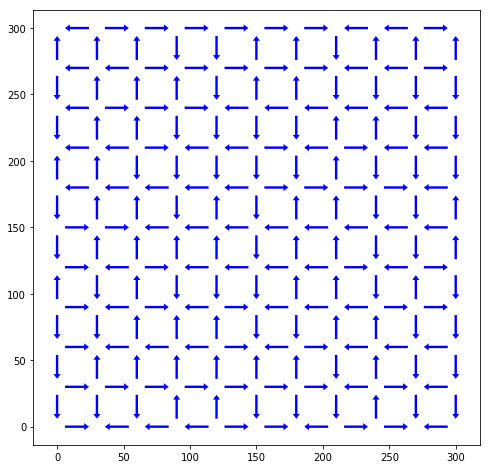

In [5]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
sp.display(ax2)

## The Colloidal Ice object

From the spins object, we can construct a `colloidal_ice`  object. To do this, we need to define some template particles and traps. These two objects will be copied to each spin in the spin ice object. This is all a way of keeping parameters tidy. 

In [6]:
particle = ice.particle(radius = 5.15*ureg.um,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(30*ureg.um)

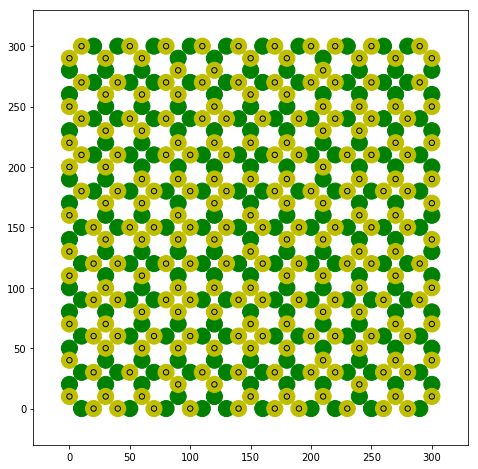

In [7]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)

## Running a simulation

Before running a simulation, we need to create a set of world parameters. This contains things like the field to be applied and the temperature.

In [8]:
world = ice.world(
    field = 10*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

To run the simulation, we use the method `simulate`. If you look at the terminal in which this notebook is running, you should see a LAMMPS output. This is the indicator that everything went well.

In [9]:
col.simulate(world,
             name = "test",
             include_timestamp = False,
             targetdir = r"C:\Users\aortiza\Desktop",
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = 60*ureg.s,
             output = ["x","y","z"])

When the simulation is finished, it automatically reads the output file and updates the system to it's last position. Therefore, we can see the result by simply displaying again the `colloidal_ice` object

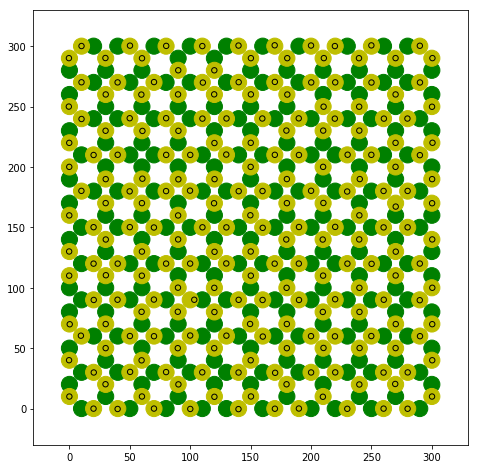

In [10]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)

To access the system state at a different time in the simulation, we can use the method `set_state_from_frame(frame)`. 

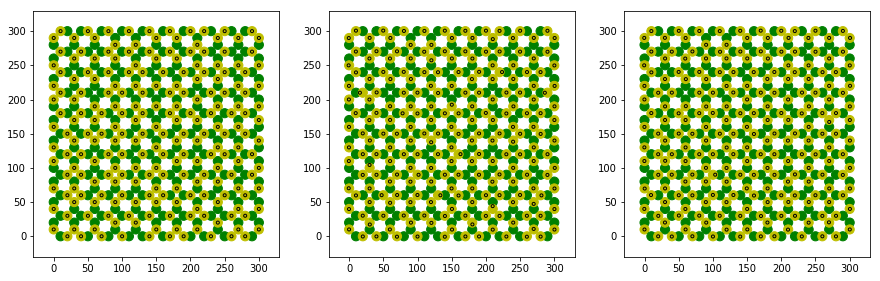

In [11]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,8))
col.set_state_from_frame(0)
col.display(ax1)
col.set_state_from_frame(3)
col.display(ax2)
col.set_state_from_frame(60)
col.display(ax3)

## Simulation trajectories

However, we might want to access the full trajectory of the particles. This is stored as a multiindex `pandas` array in the `trj` attribute. To access it, we can simply write 
    
    col.trj
    
Below we use the method `head()`, which prints only the first few rows of a pandas array. This is useful to visualize the structure of an array. 

In [12]:
col.trj.head()

type    x      y    z    t
frame id                           
0     1     1  0.0   10.0  0.1  0.0
      2     1  0.0   40.0  0.1  0.0
      3     1  0.0   70.0  0.1  0.0
      4     1  0.0  110.0  0.1  0.0
      5     1  0.0  130.0  0.1  0.0

## The multiindex pandas array

The multiindex structure is a little complicated to access at first, but it allows a lot of flexibility when slicing sections of the array. It is also the natural structure for a system of many particles and many frames. Here we show how to easily slice sections of the array. 

The first step is to define an IndexSlice object from the pandas module.

In [13]:
import pandas as pd
idx = pd.IndexSlice

Then, if for example we want to access the tenth frame we write:

In [14]:
col.trj.loc[idx[10,:],:].head()

type         x           y         z     t
frame id                                           
10    1     1 -0.511054    9.888500  3.373800  10.0
      2     1 -0.352123   39.854900  0.135311  10.0
      3     1 -0.488815   70.080704  2.632990  10.0
      4     1 -0.071804  110.112999 -1.312030  10.0
      5     1 -0.245752  129.983002  1.397560  10.0

and we can plot the points by writing:

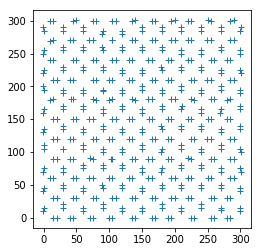

In [15]:
plt.plot(col.trj.loc[idx[10,:],"x"],col.trj.loc[idx[10,:],"y"],'+')
plt.axis("square");

### The type column

The simulation program defines traps as a type of atom. Therefore, in the resulting array, we see two atoms per `colloidal_ice` element, which are distinguished by their `type`, as can be seen in the previous image. To access only the atoms, we can use the nice logical indexing features of the pandas array.

In [16]:
trj_particle = col.trj[col.trj.type==1]
trj_particle.head()

type    x      y    z    t
frame id                           
0     1     1  0.0   10.0  0.1  0.0
      2     1  0.0   40.0  0.1  0.0
      3     1  0.0   70.0  0.1  0.0
      4     1  0.0  110.0  0.1  0.0
      5     1  0.0  130.0  0.1  0.0

And we can plot the points by writing, as before:

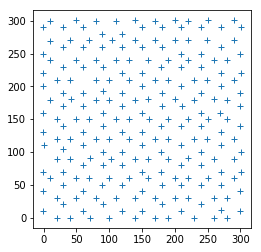

In [17]:
plt.plot(trj_particle.loc[idx[10,:],"x"],trj_particle.loc[idx[10,:],"y"],'+')
plt.axis("square");

### Drawing whole trajectories
We can plot the trajectories of the particles by writing:

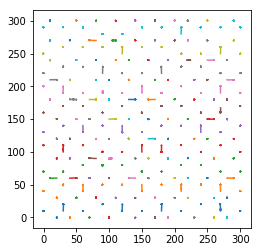

In [18]:
for i in trj_particle.index.get_level_values("id").unique():
    plt.plot(trj_particle.loc[idx[:,i],"x"],trj_particle.loc[idx[:,i],"y"])
plt.axis("square");

## Counting vertices
Often we are interested in the vertex statistics of the colloidal ice system. The package provides some counting methods bundled in the `vertices` object.

In [19]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

We can display both objects on the same axis to see where specific vertex types are located. Vertex types are defined by their charge, and when they have neutral charge, by the sum of their elements. 

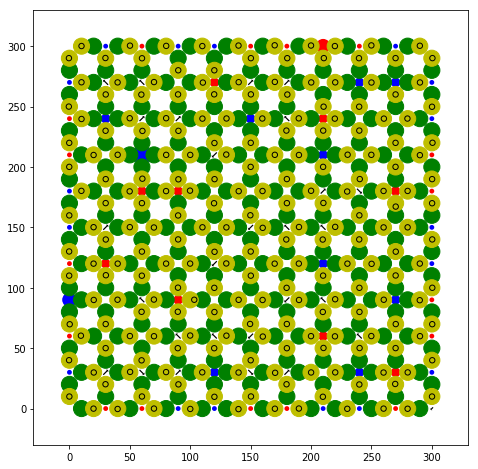

In [20]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)

Note here that the vertices are counted from the system state. If we want the vertices at different moments in time, we have to reset the system state to that frame.

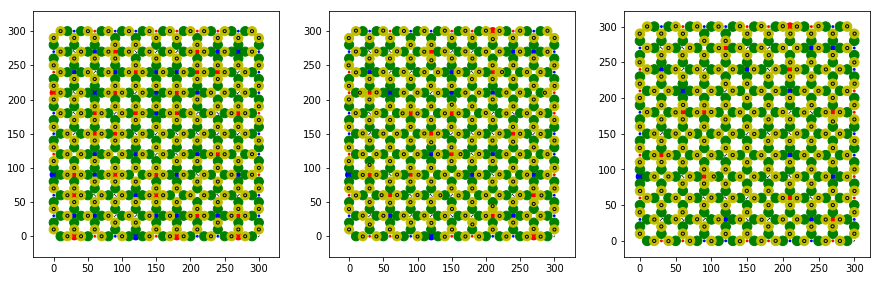

In [21]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,8))

col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)

v.display(ax1)
col.display(ax1)

col.set_state_from_frame(3)
v = v.colloids_to_vertices(col)

v.display(ax2)
col.display(ax2)

col.set_state_from_frame(60)
v = v.colloids_to_vertices(col)

v.display(ax3)
col.display(ax3)

## Honeycomb Spin Ice

We will try the exact same procedure with a Honeycomb configuration to ensure everything works

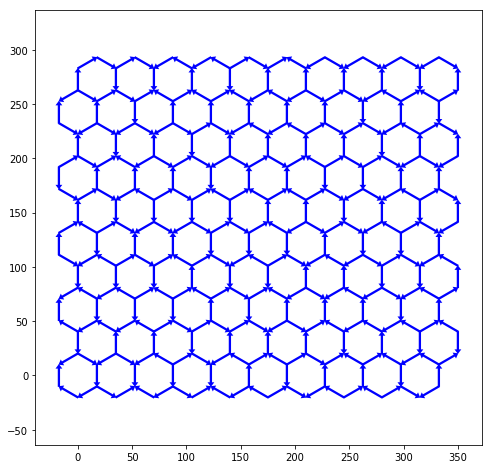

In [22]:
sp = ice.spins()
sp.create_lattice("honeycomb",[10,10],lattice_constant=35*ureg.um)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
sp.display(ax1)

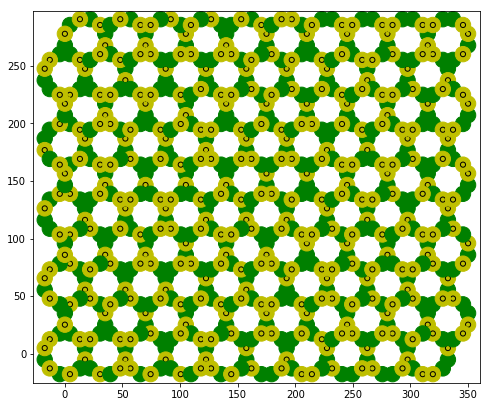

In [23]:
particle = ice.particle(radius = 5.15*ureg.um,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)
 
trap = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(10*ureg.um)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
col.display(ax1)

In [24]:
world = ice.world(
    field = 10*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 20*ureg.um)

col.simulate(world,
             name = "test",
             include_timestamp = False,
             targetdir = r"C:\Users\aortiza\Desktop",
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = 60*ureg.s,
             output = ["x","y","z"])

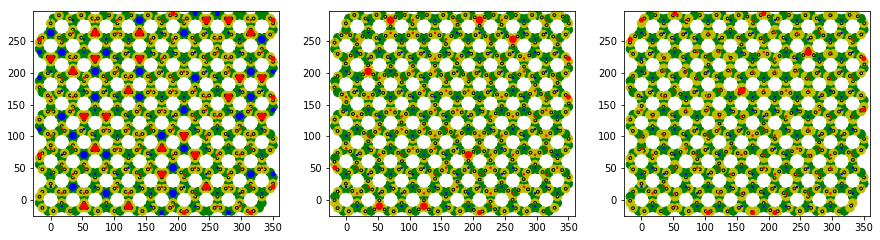

In [25]:
v = ice.vertices()
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,8))

col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)

col.set_state_from_frame(3)
v = v.colloids_to_vertices(col)

col.display(ax2)
v.display(ax2)

col.set_state_from_frame(60)
v = v.colloids_to_vertices(col)

col.display(ax3)
v.display(ax3)